## Lab 2
### Part 2: Dealing with overfitting

Today we work with [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) (*hint: it is available in `torchvision`*).

Your goal for today:
1. Train a FC (fully-connected) network that achieves >= 0.885 test accuracy.
2. Cause considerable overfitting by modifying the network (e.g. increasing the number of network parameters and/or layers) and demonstrate in in the appropriate way (e.g. plot loss and accurasy on train and validation set w.r.t. network complexity).
3. Try to deal with overfitting (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

__Please, write a small report describing your ideas, tries and achieved results in the end of this file.__

*Note*: Tasks 2 and 3 are interrelated, in task 3 your goal is to make the network from task 2 less prone to overfitting. Task 1 is independent from 2 and 3.

*Note 2*: We recomment to use Google Colab or other machine with GPU acceleration.

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchsummary
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import os


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [ ]:
# Technical function
def mkdir(path):
    if not os.path.exists(root_path):
        os.mkdir(root_path)
        print('Directory', path, 'is created!')
    else:
        print('Directory', path, 'already exists!')
        
root_path = 'fmnist'
mkdir(root_path)

Directory fmnist is created!


In [ ]:
download = True
train_transform = transforms.ToTensor()
test_transform = transforms.ToTensor()
transforms.Compose((transforms.ToTensor()))


fmnist_dataset_train = torchvision.datasets.FashionMNIST(root_path, 
                                                        train=True, 
                                                        transform=train_transform,
                                                        target_transform=None,
                                                        download=download)
fmnist_dataset_test = torchvision.datasets.FashionMNIST(root_path, 
                                                       train=False, 
                                                       transform=test_transform,
                                                       target_transform=None,
                                                       download=download)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting fmnist/FashionMNIST/raw/train-images-idx3-ubyte.gz to fmnist/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting fmnist/FashionMNIST/raw/train-labels-idx1-ubyte.gz to fmnist/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting fmnist/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to fmnist/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting fmnist/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to fmnist/FashionMNIST/raw



In [ ]:
train_loader = torch.utils.data.DataLoader(fmnist_dataset_train, 
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)
test_loader = torch.utils.data.DataLoader(fmnist_dataset_test,
                                          batch_size=256,
                                          shuffle=False,
                                          num_workers=2)

In [ ]:
len(fmnist_dataset_test)

10000

In [ ]:
for img, label in train_loader:
    print(img.shape)
#     print(img)
    print(label.shape)
    print(label.size(0))
    break

torch.Size([128, 1, 28, 28])
torch.Size([128])
128


### Task 1
Train a network that achieves $\geq 0.885$ test accuracy. It's fine to use only Linear (`nn.Linear`) layers and activations/dropout/batchnorm. Convolutional layers might be a great use, but we will meet them a bit later.

In [ ]:
class TinyNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, 500, bias=False), 
            nn.BatchNorm1d(500),
            nn.ELU(),
            nn.Linear(500, 250, bias=False),
            nn.BatchNorm1d(250),
            nn.ELU(),
            nn.Linear(250, num_classes)
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [ ]:
torchsummary.summary(TinyNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 500]         392,000
       BatchNorm1d-3                  [-1, 500]           1,000
               ELU-4                  [-1, 500]               0
            Linear-5                  [-1, 250]         125,000
       BatchNorm1d-6                  [-1, 250]             500
               ELU-7                  [-1, 250]               0
            Linear-8                   [-1, 10]           2,510
Total params: 521,010
Trainable params: 521,010
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 1.99
Estimated Total Size (MB): 2.01
----------------------------------------------------------------


Your experiments come here:

In [ ]:
model = TinyNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, patience=3)
# Your experiments, training and validation loops here
def train_model(model, train_loader, loss_fn, opt, n_epochs, lr_scheduler=None):
    for epoch in range(n_epochs):
        model.train(True) # enable dropout / batch_norm training behavior
        for X_batch, y_batch in train_loader:
            # move data to target device
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            # train on batch: compute loss, calc grads, perform optimizer step and zero the grads
            preds = model.forward(X_batch)
            loss = loss_fn(preds, y_batch)
            loss.backward()
            opt.step()
            opt.zero_grad()

        if lr_scheduler:
            lr_scheduler.step(loss)

train_model(model, train_loader, loss_func, opt, n_epochs=16, lr_scheduler=lr_scheduler)

In [ ]:
def test_model(model, test_loader):
    with torch.no_grad():
        model.eval()
        right_preds, total_preds = 0, 0
    
        for inputs, targets in test_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            preds = model(inputs)
            right_preds += torch.sum(preds.argmax(dim=1) == targets).item()
            total_preds += targets.size()[0]
            
    return right_preds / total_preds

test_acc = test_model(model, test_loader)
print("Test accuracy =", test_acc)

Test accuracy = 0.8889


### Task 2: Overfit it.
Build a network that will overfit to this dataset. Demonstrate the overfitting in the appropriate way (e.g. plot loss and accurasy on train and test set w.r.t. network complexity).

*Note:* you also might decrease the size of `train` dataset to enforce the overfitting and speed up the computations.

In [ ]:
class OverfittingNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, 50000), 
            nn.LeakyReLU(), 
            nn.Linear(50000, 10)
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [ ]:
torchsummary.summary(OverfittingNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                [-1, 50000]      39,250,000
         LeakyReLU-3                [-1, 50000]               0
            Linear-4                   [-1, 10]         500,010
Total params: 39,750,010
Trainable params: 39,750,010
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.77
Params size (MB): 151.63
Estimated Total Size (MB): 152.41
----------------------------------------------------------------


In [ ]:
model = OverfittingNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, patience=3)
# Your experiments, come here
def train_val_model(model, train_loader, val_loader, loss_fn, opt, n_epochs, 
                                                            lr_scheduler=None):
    train_loss, train_accuracy = [], []
    val_loss, val_accuracy = [], []
    
    for epoch in range(n_epochs):
        ep_train_loss, ep_train_accuracy = [], []
        ep_val_loss, ep_val_accuracy = [], []
        model.train(True) # enable dropout / batch_norm training behavior
        for X_batch, y_batch in train_loader:
            # move data to target device
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            # train on batch: compute loss, calc grads, perform optimizer step and zero the grads
            preds = model.forward(X_batch)
            loss = loss_fn(preds, y_batch)
            loss.backward()
            opt.step()
            opt.zero_grad()

            y_pred = preds.argmax(dim=1)
            acc = torch.sum(y_pred == y_batch).item() / y_batch.size()[0]

            ep_train_accuracy.append(acc)
            ep_train_loss.append(loss.item())

        if lr_scheduler:
            lr_scheduler.step(loss)
        
        model.train(False) # disable dropout / use averages for batch_norm
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                # move data to target device
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)
                # compute predictions
                preds = model.forward(X_batch)
                loss = loss_fn(preds, y_batch)
                ep_val_loss.append(loss.item())

                y_pred = preds.argmax(dim=1)
                acc = torch.sum(y_pred == y_batch).item() / y_batch.size()[0]
                ep_val_accuracy.append(acc)

        # print the results for this epoch:
        train_loss.append(np.mean(ep_train_loss))
        train_accuracy.append(np.mean(ep_train_accuracy))
        val_loss.append(np.mean(ep_val_loss))
        val_accuracy.append(np.mean(ep_val_accuracy))

    return train_loss, train_accuracy, val_loss, val_accuracy

train_loss, train_acc, val_loss, val_acc = train_val_model(model, 
                                                      train_loader, 
                                                      test_loader, 
                                                      loss_func, 
                                                      opt, 
                                                      n_epochs=12, 
                                                      lr_scheduler=lr_scheduler)

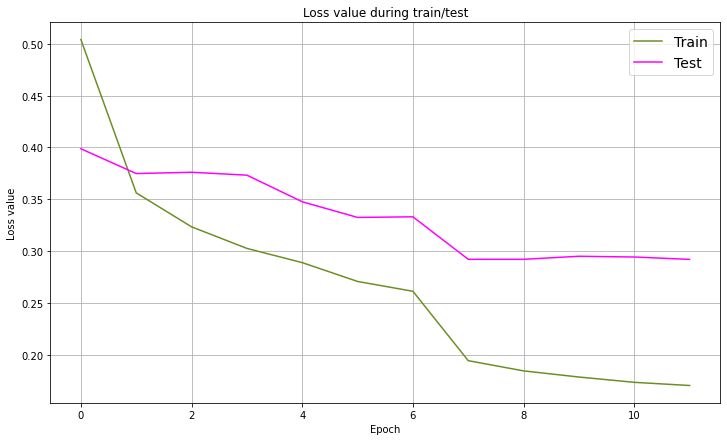

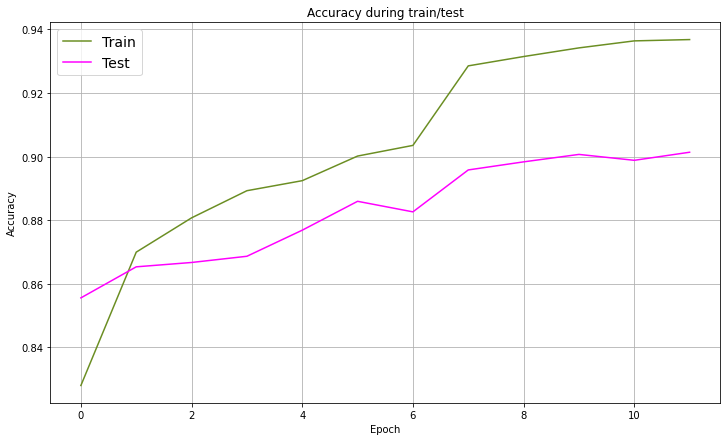

In [ ]:
colors = ('olivedrab', 'magenta')

def plot_training_results(train_data, val_data, ylabel="Loss value"):
    plt.figure(figsize=(12, 7))
    plt.plot(train_data, color=colors[0], label="Train")
    plt.plot(val_data, color=colors[1], label="Test")

    plt.title(f"{ylabel} during train/test")
    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.legend(fontsize=14)
    plt.show()

plot_training_results(train_loss, val_loss)
plot_training_results(train_acc, val_acc, ylabel="Accuracy")

### Task 3: Fix it.
Fix the overfitted network from the previous step (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results. 

In [ ]:
#Dropout
class FixedNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, 50000), 
            nn.Dropout(p=0.7),
            nn.LeakyReLU(), 
            nn.Linear(50000, 10)
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [ ]:
torchsummary.summary(FixedNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                [-1, 50000]      39,250,000
           Dropout-3                [-1, 50000]               0
         LeakyReLU-4                [-1, 50000]               0
            Linear-5                   [-1, 10]         500,010
Total params: 39,750,010
Trainable params: 39,750,010
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 1.15
Params size (MB): 151.63
Estimated Total Size (MB): 152.79
----------------------------------------------------------------


In [ ]:
model = FixedNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, patience=3)

# Your experiments, come here
train_loss, train_acc, val_loss, val_acc = train_val_model(model, 
                                                      train_loader, 
                                                      test_loader, 
                                                      loss_func, 
                                                      opt, 
                                                      n_epochs=12, 
                                                      lr_scheduler=lr_scheduler)

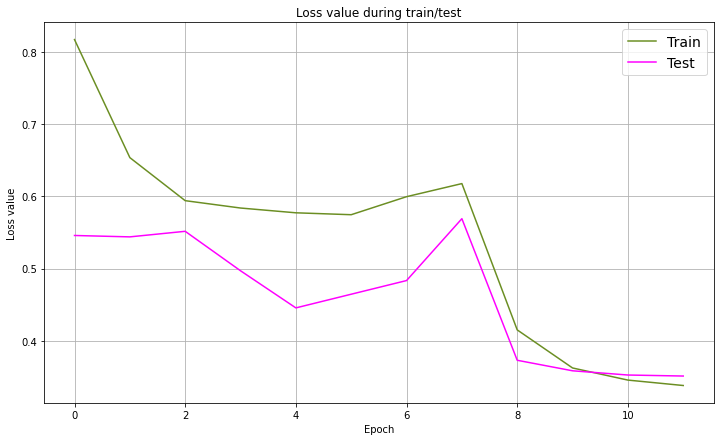

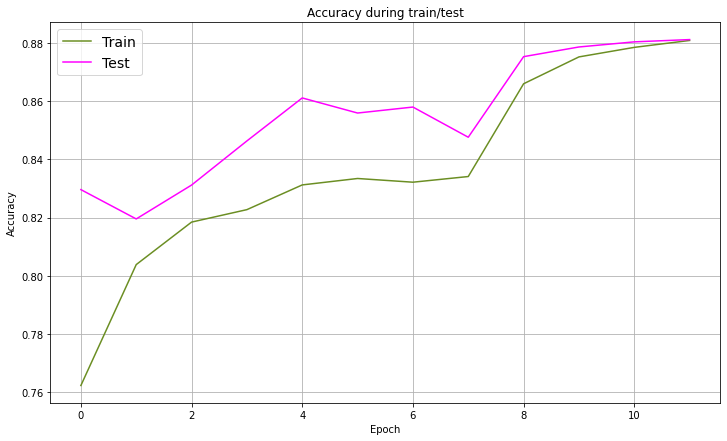

In [ ]:
plot_training_results(train_loss, val_loss)
plot_training_results(train_acc, val_acc, ylabel="Accuracy")

In [ ]:
#Batchnorm
class FixedNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), 
            nn.Linear(input_shape, 50000), 
            nn.BatchNorm1d(50000),
            nn.LeakyReLU(), 
            nn.Linear(50000, 10)
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

model = FixedNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, patience=4)

train_loss, train_acc, val_loss, val_acc = train_val_model(model, 
                                                      train_loader, 
                                                      test_loader, 
                                                      loss_func, 
                                                      opt, 
                                                      n_epochs=12, 
                                                      lr_scheduler=lr_scheduler)

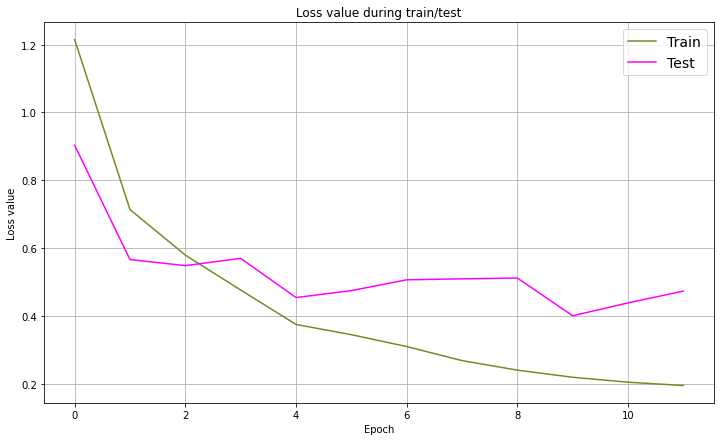

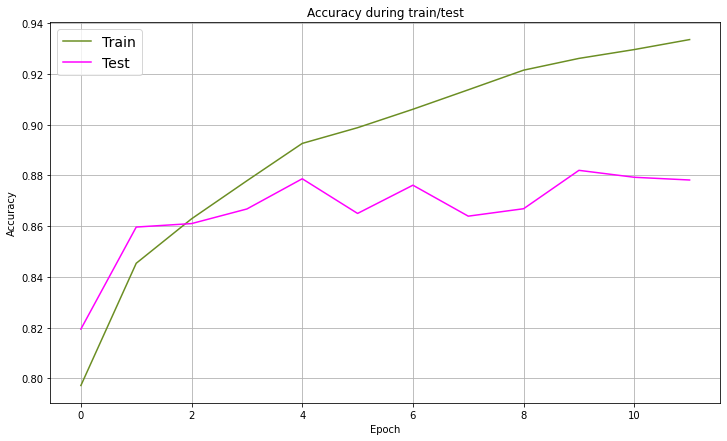

In [ ]:
plot_training_results(train_loss, val_loss)
plot_training_results(train_acc, val_acc, ylabel="Accuracy")

### Conclusions:
_Write down small report with your conclusions and your ideas._

Several approaches have been applied to combat overfitting: adding BatchNormalization and DropOut to the model

Dropout significantly lowered the effectiveness of retraining since the model did not adapt to the values of specific attributes because some neurons were "turned off" during model training.

BatchNormalization, on the other hand, was unable to resolve the retraining issue for our model because of the way in which its regularisation effect is structured: this layer minimises the internal covariate shift, which is a shift in the distribution of the network parameters that occurs during training, and stabilises the distribution of the network parameters (namely, the mean and variance)